# Reading and storing data utility functions

In [1]:
import json

filename = 'top_10_CS_researcher_all_publications.json'

def read_data(filepath=filename):
    with open(filepath, 'r') as fp:
        return json.load(fp)

def store_data(data, filepath=filename):
    with open(filepath, 'w') as fp:
        return json.dump(data, fp)

# Fetch Publications for an author

In [2]:
import pycountry
import pandas as pd
import requests
import xmltodict

# Read the Stanford 2% ranking excel file
df = pd.read_excel('Table_1_Authors_career_2022_pubs_since_1788_wopp_extracted_202310.xlsx', sheet_name='Data', engine='openpyxl')
# We are only considering the Computer Science subject for this study
df = df.loc[df['sm-field'] == 'Information & Communication Technologies']
# A mapping between Stanford's top 2% ranking `sm-field` and Scopus API `SUBJECTAREA`
subject_areas_mapping = {
    'Information & Communication Technologies': ['COMP', 'MULT']
}

# Set up your Scopus API key
api_key = '5aa908d24ec7e71ef0cf68cb3bff134d'

# Define the Scopus API endpoint for author search
scopus_search_url = 'https://api.elsevier.com/content/search/author'

# Define the Scopus API endpoint for retrieving author's publications
scopus_search_publications_url = 'https://api.elsevier.com/content/search/scopus'

# Define the Scopus Abstract Retrieval API to get detailed information about the publication
scopus_abstract_url = f'https://api.elsevier.com/content/abstract/eid'

# Set up headers with your API key
headers = {
    'X-ELS-APIKey': api_key,
}

# Utility methods
def get_author_names(author_full_name):
    # Split the full name into first and last names
    names = author_full_name.split(', ', 1)
    first_name = names[-1]
    last_name = names[0] if len(names)==2 else ''
    return first_name, last_name

def get_country_name(country_code):
    try:
        country_name = pycountry.countries.get(alpha_3=country_code).name
        return country_name
    except AttributeError:
        # Handle cases where the country code is not found
        return ''

In [3]:
# Function to search for an author in Scopus using name, affiliation, country, and field
def search_author(author_name, affiliation, country_code, field):
    first_name, last_name = get_author_names(author_name)
    subject_areas = subject_areas_mapping.get(field, [])
    country_name = get_country_name(country_code)

    query = f'AUTHLASTNAME({last_name}) AND AUTHFIRST({first_name}) AND {" OR ".join(map(lambda s: f"SUBJAREA({s})", subject_areas))}'
    response = requests.get(scopus_search_url, params={'query': query, 'count': 200}, headers=headers)

    if response.status_code == 200:
        results = response.json().get('search-results', {}).get('entry', [])
        results.sort(key=lambda x: x.get('document-count', 0), reverse=True)
        results.sort(key=lambda x: x.get('affiliation-current', {}).get('affiliation-country', '') == country_name, reverse=True)
        # Affiliation is excluded as it can change
        # results.sort(key=lambda x: x.get('affiliation-current', {}).get('affiliation-name', '') == affiliation, reverse=True)
        return results[0] if results else None
    else:
        return None

In [4]:
# Function to fetch all publications for an author using Scopus Author ID
def fetch_author_publications(author_id, publications=None, start_index=0):
    if not publications:
        publications = []

    query = f'AU-ID({author_id})'
    response = requests.get(scopus_search_publications_url, params={'query': query, 'start': start_index, 'count': 200}, headers=headers)

    if response.status_code == 200:
        search_results = response.json().get('search-results', {}).get('entry', [])

        for entry in search_results:
            authors = []
            # Retrieve co-author details if any citations for the publication else default to empty list because costly operation
            if int(entry.get('citedby-count', 0)) > 0:
                abstract_url = f'{scopus_abstract_url}/{entry.get("eid", "")}'
                response_abstract = requests.get(abstract_url, headers=headers)
                if response_abstract.status_code == 200:
                    author_data = xmltodict.parse(response_abstract.text).get('abstracts-retrieval-response', {}).get('authors', []).get('author', [])
                    if not isinstance(author_data, list): # If only one author
                        author_data = [author_data]
                    authors = map(lambda a: {
                            'scopus_id': a['@auid'],
                            'name': a.get('ce:indexed-name', ''),
                        }, author_data)

            publication_data = {
                'title': entry.get('dc:title', ''),
                'eid': entry.get('eid', ''),
                'citations': entry.get('citedby-count', 0),
                'authors': list(authors),
                'publication_name': entry.get('prism:publicationName', ''),
                'issn': entry.get('prism:issn', ''),
                'cover_date': entry.get('prism:coverDate', ''),
                'venue': entry.get('prism:aggregationType', ''),
                'volume': entry.get('prism:volume', ''),
                'issue': entry.get('prism:issueIdentifier', ''),
                'page_range': entry.get('prism:pageRange', ''),
                'doi': entry.get('prism:doi', ''),
            }
            publications.append(publication_data)

        # Fetch the next set of publications if available
        start_index += len(search_results)
        if start_index < int(response.json().get('search-results', {}).get('opensearch:totalResults', 0)):
            return fetch_author_publications(author_id, publications, start_index)

    return publications

In [8]:
stop_at = 30
scopus_results = read_data()

# Iterate through the rows of the DataFrame
for index, (row_index, row) in enumerate(df.iterrows()):
    if index < len(scopus_results):
        # Since data was previously obtained for these authors, we can skip them
        print(f'{row["authfull"]}: Skipped')
        continue

    author_name = row['authfull']
    author_cscore = row['c']
    affiliation = row['inst_name']
    country_code = row['cntry']
    field = row['sm-field']
    print(author_name)

    # Search for the author in Scopus
    author_search_result = search_author(author_name, affiliation, country_code, field)

    # Process the search result as needed
    if author_search_result is not None:
        author_id = author_search_result.get('dc:identifier', '').split(':')[-1]
        author_publications = fetch_author_publications(author_id)
        scopus_results.append({
            'scopus_id': author_id,
            'name': author_name,
            'cscore': author_cscore,
            'publications': author_publications
        })
        if index == stop_at:
            break
    else:
        print(f"Author not found for: {author_name}, Affiliation: {affiliation}, Country: {country_code}, Field: {field}")

store_data(scopus_results)
# Find the remaining usage-limit for Scopus API


Zadeh, Lotfi A.: Skipped
Hinton, Geoffrey: Skipped
Jain, Anil: Skipped
Bengio, Yoshua: Skipped
Donoho, David: Skipped
Yager, Ronald R.: Skipped
Xu, Zeshui: Skipped
van der Aalst, Wil M.P.: Skipped
Deb, Kalyanmoy: Skipped
Lowe, David G.: Skipped
Schmidhuber, Jürgen: Skipped
Yang, Xin She: Skipped
Kleinberg, Jon: Skipped
Venkatesh, Viswanath: Skipped
Shannon, Claude E.: Skipped
Pentland, Alex Sandy: Skipped
Goldsmith, Andrea: Skipped
Stamatakis, Alexandros: Skipped
Jordan, Michael I.: Skipped
Girshick, Ross: Skipped
Mallat, Stéphane: Skipped
Mirjalili, Seyedali: Skipped
Cao, Jinde: Skipped
Shamir, Adi: Skipped
Herrera, Francisco: Skipped
Pedrycz, Witold: Skipped
Blei, David M.: Skipped
Zhou, Zhi Hua
Akyildiz, Ian F.
Han, Jiawei
Shneiderman, Ben


In [7]:
len(scopus_results)

# Calculate Metrics for the Author

In [2]:
import json
with open('top_10_CS_researcher_all_publications.json', 'r') as fp:
    authors = json.load(fp)

In [5]:
import pandas as pd
from calculate import *
from IPython.display import display

'''
We find the top 20 authors in Computer Science - based on h-index
We find the top 100 pubs for the author and then
We calculate
* h-index
* c-score
* h-leadership-index (inverted bell curve)

display them in a web application (pdf, link, report)

In stanford, hm, h-frac, 10000
finding how many are noble laureates

not ranking but an index
cscore does not include Field-wise citation index
'''

rows = []
authors = read_data()
for author in authors:
    try:
        rows.append({
            'Name': author['name'],
            'Publications': len(author['publications']),
            'Total citations': total_citations(author['publications']),
            'Median citations': median_citations(author['publications']),
            'h-index': h_index(author['publications']),
            'h-frac-index': h_frac_index(author['publications']),
            'hm-index': hm_index(author['publications']),
            'h-leadership-index': h_leadership_index(author['scopus_id'], author['publications']),
            '% first author': percent_first_author(author['scopus_id'], author['publications']),
            '% last author': percent_last_author(author['scopus_id'], author['publications']),
            '% single author': percent_single_author(author['publications']),
            'Median author position': median_author_position(author['scopus_id'], author['publications']),
            # 'cscore':
            'i10-index': i10_index(author['publications']),
            'Average number of Authors': mean_coauthors(author['publications']),
            'Median number of Authors': median_coauthors(author['publications']),
        })
    except:
        print(f"Error processing author: {author['name']}")

df = pd.DataFrame(rows)
display(df)

Average leadership weight: 0.8051164035299015
Average leadership weight: 0.9343305002312846
Average leadership weight: 0.9011839608201546
Average leadership weight: 0.8944597493064508
Average leadership weight: 0.9170395783106251
Average leadership weight: 0.8339871153517104
Average leadership weight: 0.8402824300923679
Average leadership weight: 0.8371145376346012
Average leadership weight: 0.8461628542080133
Average leadership weight: 0.8789996108384804
Average leadership weight: 0.8677914094241627
Average leadership weight: 0.8137188213260211
Average leadership weight: 0.8381001744902968
Average leadership weight: 0.9046585160239898
Average leadership weight: 0.9381964551213542
Average leadership weight: 0.8614688036301276
Average leadership weight: 0.9116462605533756
Average leadership weight: 0.8476833425766122
Average leadership weight: 0.7205973654835586
Average leadership weight: 0.9184359629558807
Average leadership weight: 0.9042769491634658
Average leadership weight: 0.85316

/home/hardik/Desktop/research/metrics/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/hardik/Desktop/research/metrics/venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Average leadership weight: 0.8797536457191091
Average leadership weight: 0.8569220986011866


,Name,Publications,Total citations,Median citations,h-index,h-frac-index,hm-index,h-leadership-index,% first author,% last author,% single author,Median author position,i10-index,Average number of Authors,Median number of Authors
0,"Zadeh, Lotfi A.",268,138014,9.5,63,42,185,63,84.403670,90.825688,80.733945,1.0,134,1.770642,1.0
1,"Hinton, Geoffrey",265,389243,82.0,111,49,111,108,21.400778,72.373541,11.284047,2.0,223,3.027237,3.0
2,"Jain, Anil",795,111640,34.0,150,52,282,147,17.158177,65.683646,1.876676,2.0,575,3.012064,3.0
3,"Bengio, Yoshua",551,359328,32.0,146,41,137,141,15.134100,55.172414,2.107280,4.0,401,5.126437,4.0
4,"Donoho, David",203,100027,60.0,86,56,86,85,50.259067,40.414508,11.398964,1.0,163,2.901554,2.0
5,"Yager, Ronald R.",886,55487,10.0,100,46,538,99,68.085106,79.654255,53.989362,1.0,451,1.855053,1.0
6,"Xu, Zeshui",1072,66477,16.0,130,61,387,128,18.569904,46.958378,10.565635,2.0,646,2.979723,3.0
7,"van der Aalst, Wil M.P.",977,60458,17.0,118,16,303,114,24.210526,63.625731,10.058480,3.0,607,3.719298,3.0
8,"Deb, Kalyanmoy",644,85064,15.0,87,34,200,85,21.441125,51.318102,4.217926,2.0,374,3.263620,3.0
9,"Lowe, David G.",87,77999,36.0,40,28,38,40,22.784810,78.481013,17.721519,2.0,66,2.772152,2.0


* We chose to assign weights based on a normalised inverse gaussian curve
* Since the center of the normalise inverse gaussian curve can be zero, we chose to exclude the region.

In [8]:
# Hinton single author papers
df.iloc[1]['Publications']

Name                  Hinton, Geoffrey
Publications                       265
Citations                       389243
h-index                            111
h-frac-index                        49
hm-index                           111
h-leadership-index                 108
% first author               23.396226
% last author                72.075472
% single author               12.45283
Name: 1, dtype: object

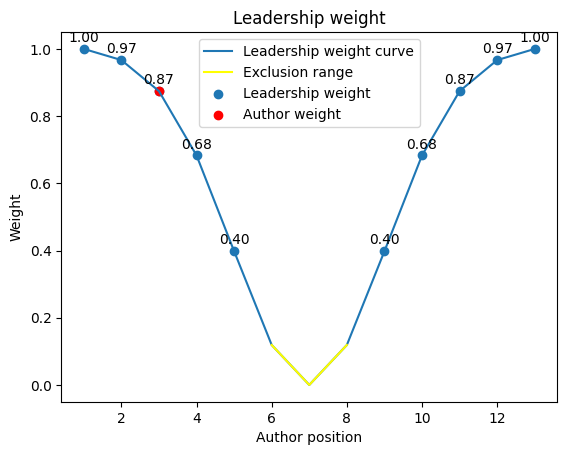

In [113]:
plot_leadership_weight(2, 10, annotate=True)

### Problem
* For a particular position, the increase in authors should lead to a decrease in weight but the opposite is happening.
* This is because the authorship positions are spread linearly across the inverse gaussian curve so an increase of authors leads one position to move closer to the edges.
* Right now, the normalisation is implemented so that the first and last authors have a weight of 1.
```
Authors Position Weight
2       2        1.0
3       2        0.77
4       2        0.87
5       2        0.90
6       2        0.93
```
How to solve this problem?
Maybe by not linearly distributing the authorship position across the gaussian distribution but moving it logarithmically closer to the center

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_leadership_weight2(author_position, n=1, mean=0, std_dev=1, annotate=False):
    # Logarithmically reduce the weights based on the author's position
    author_positions = np.arange(0, n)
    author_positions_reindexed = np.array([author_position if author_position <= n/2 else n-author_position-1 for author_position in author_positions])
    author_weights = 1/(1+np.log(1+author_positions_reindexed))

    plt.plot(author_positions+1, author_weights, label='Leadership weight curve')

    # Plot all authors' weights
    plt.scatter(author_positions+1, author_weights, label='Leadership weight')
    if annotate:
        for x, y in zip(author_positions+1, author_weights):
            plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,5), ha='center')

    plt.scatter(author_position+1, author_weights[author_position], label='Author weight', color='red')
    plt.xlabel('Author position')
    plt.ylabel('Weight')
    plt.title('Leadership weight')
    plt.legend()
    plt.show()

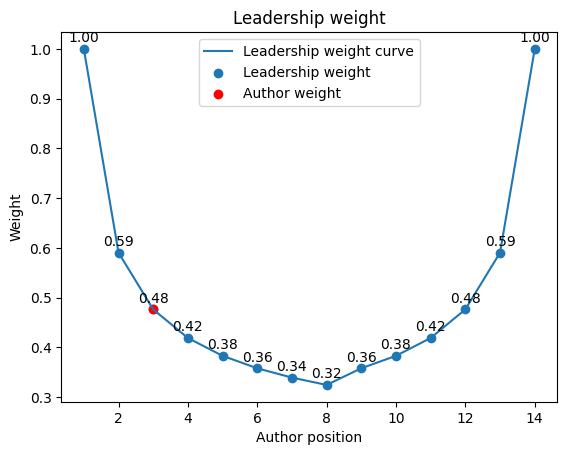

In [9]:
plot_leadership_weight2(author_position=2, n=14, annotate=True)

1.0 1.0


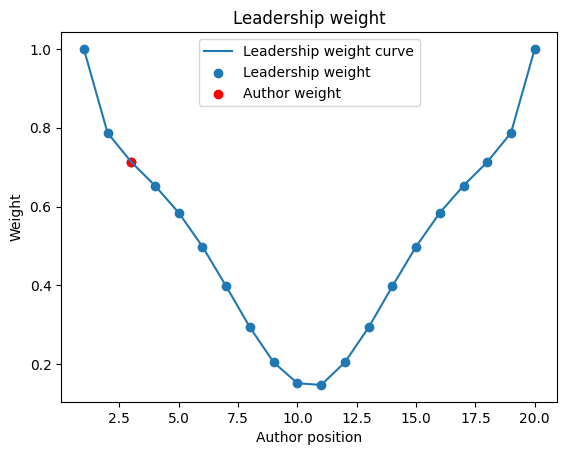

In [60]:
import numpy as np
import matplotlib.pyplot as plt

def plot_leadership_weight3(author_position, n=1, mean=0, std_dev=1, annotate=False):
    # Gaussian: we generate three extra points in the center for exclusion
    
    x_values = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, n)
    y_values = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-(x_values - mean)**2 / (2 * std_dev**2))
    # Inverse Gaussian
    inv_gaussian = 1 - y_values
    # Normalize so that the maximum weight is 1 for first and last author
    inv_gaussian = (inv_gaussian - np.min(inv_gaussian))/ (np.max(inv_gaussian) - np.min(inv_gaussian))

    # weight_index = author_position if author_position < n/2 else author_position
    # inv_gaussian_weights = inv_gaussian[weight_index]

    # Logarithmically reduce the weights based on the author's position
    author_positions = np.arange(0, n)
    author_positions_reindexed = np.array([author_position if author_position <= n/2 else n-author_position-1 for author_position in author_positions])
    logarithmic_weights = 1/(1+np.log(1+author_positions_reindexed))

    print(inv_gaussian[0], logarithmic_weights[0])

    author_weights = (inv_gaussian + logarithmic_weights) / 2

    plt.plot(author_positions+1, author_weights, label='Leadership weight curve')

    # Plot all authors' weights
    plt.scatter(author_positions+1, author_weights, label='Leadership weight')
    if annotate:
        for x, y in zip(author_positions+1, author_weights):
            plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,5), ha='center')

    plt.scatter(author_position+1, author_weights[author_position], label='Author weight', color='red')
    plt.xlabel('Author position')
    plt.ylabel('Weight')
    plt.title('Leadership weight')
    plt.legend()
    plt.show()

plot_leadership_weight3(author_position=2, n=20, annotate=False)

### Advantages of logarithmic approach over inverse gaussian approach
* fixes increasing author weight problem due to increasing number of authors for a fixed position

### Disadvantages
* Too big a drop between first and second author positions
* An author's position fixes their weight, the number of authors do not contribute

### Aim: When determining ranking
* Account number of authors
* Account position of author

In [54]:
def plot_leadership_weight4(author_position, n=1, mean=0, std_dev=1, annotate=False):
    # Gaussian: we generate three extra points in the center for exclusion
    extra_center_points = 3
    x_values = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, n+extra_center_points)
    y_values = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-(x_values - mean)**2 / (2 * std_dev**2))
    # Inverse Gaussian
    inv_gaussian = 1 - y_values
    # Normalize so that the maximum weight is 1 for first and last author
    inv_gaussian = (inv_gaussian - np.min(inv_gaussian))/ (np.max(inv_gaussian) - np.min(inv_gaussian))
    inv_gaussian = inv_gaussian/(1+np.log(1+n))*1.69

    weight_index = author_position if author_position < n/2 else author_position+extra_center_points
    weight = inv_gaussian[weight_index]

    plt.plot(range(1, len(inv_gaussian)+1), inv_gaussian, label='Leadership weight curve')

    # Plot the exclusion three points range at the center
    exclusion_range = np.array(range(int(n/2), int(n/2)+extra_center_points))
    plt.plot(exclusion_range+1, inv_gaussian[exclusion_range], color='yellow', label='Exclusion range')

    # Plot all authors' weights
    x_range = np.delete(range(1, len(inv_gaussian)+1), exclusion_range)
    y_range = np.delete(inv_gaussian, exclusion_range)
    plt.scatter(x_range, y_range, label='Leadership weight')
    if annotate:
        for x, y in zip(x_range, y_range):
            plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,5), ha='center')

    plt.scatter(weight_index+1, weight, label='Author weight', color='red')
    plt.xlabel('Author position')
    plt.ylabel('Weight')
    plt.title('Leadership weight')
    plt.legend()
    plt.show()

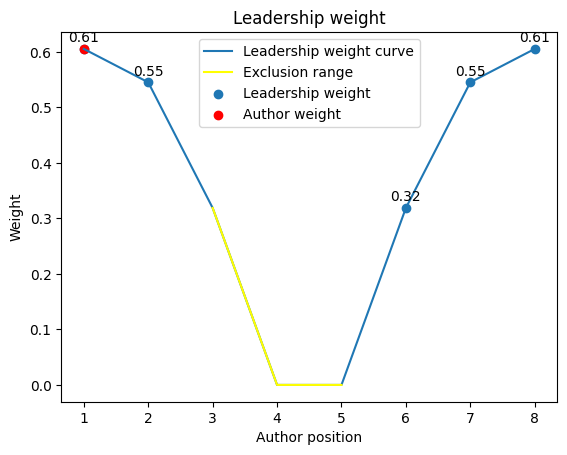

In [56]:
plot_leadership_weight4(author_position=0, n=5, annotate=True)

1.6931471805599454 0.9595022136880896


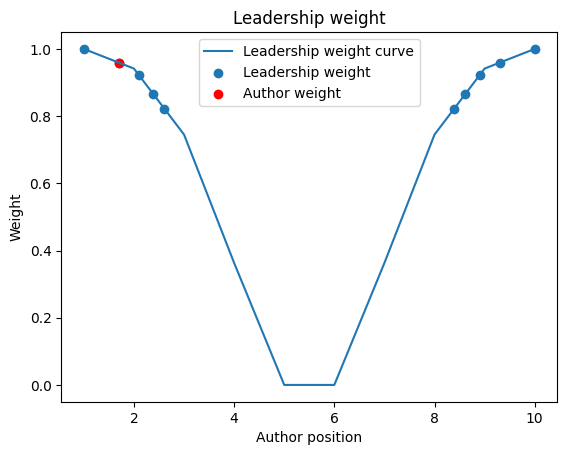

In [123]:
# <5: first author weight 1
# 5-100: first author weight 0.95-0.3
# 100 or more: first author weight 0.3

def plot_leadership_weight_final(author_position=1, n=1, mean=0, std_dev=1, annotate=False):
    # Gaussian
    x_values = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, n)
    y_values = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-(x_values - mean)**2 / (2 * std_dev**2))
    # Inverse Gaussian
    inv_gaussian = 1 - y_values
    # Normalize so that the maximum weight is 1 for first and last author
    inv_gaussian = (inv_gaussian - np.min(inv_gaussian))/ (np.max(inv_gaussian) - np.min(inv_gaussian))

    author_positions = np.arange(1, n+1)
    author_positions_logarithmic = np.array([1+np.log(author_pos) if author_pos<=n/2 else n-np.log(1+n-author_pos) for author_pos in author_positions])
    author_weights = np.interp(author_positions_logarithmic, author_positions, inv_gaussian)

    author_position_logarithmic = author_positions_logarithmic[author_position-1]
    author_weight = author_weights[author_position-1]

    print(author_position_logarithmic, author_weight)

    plt.plot(author_positions, inv_gaussian, label='Leadership weight curve')

    # Plot all authors' weights
    plt.scatter(author_positions_logarithmic, author_weights, label='Leadership weight')
    if annotate:
        for x, y in zip(author_positions_logarithmic, author_weights):
            plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,5), ha='center')

    plt.scatter(author_position_logarithmic, author_weight, label='Author weight', color='red')
    plt.xlabel('Author position')
    plt.ylabel('Weight')
    plt.title('Leadership weight')
    plt.legend()
    plt.show()

plot_leadership_weight_final(2, 10, annotate=False)

# Gaussian should not shift based on n
# Author position should detwermine weight alone